## Write Your Own Random Forest

In [0]:
!pip install -q fastai==0.7.0 torchtext==0.2.3

In [0]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [0]:
PATH = Path("data/house_price/")
os.makedirs(PATH, exist_ok=True)

In [0]:
!kaggle competitions download -c house-prices-advanced-regression-techniques -p {PATH}

## Single Tree

### Only 2 columns

In [0]:
train_df = pd.read_csv(PATH/'train.csv')
y = np.log1p(train_df.SalePrice).values
x = train_df[['OverallQual', 'GrLivArea']].copy()
trn_x, val_x, trn_y, val_y = train_test_split(x, y, test_size=0.3)
len(trn_x), len(trn_y), len(val_x), len(val_y)

(1022, 1022, 438, 438)

In [0]:
n = 1000
trn_x, trn_y = trn_x[:n], trn_y[:n]

In [0]:
class RandomForest():
  def __init__(self, x, y, nr_trees, sample_sz=1000):
    self.x, self.y, self.nr_trees, self.sample_sz = x, y, nr_trees, sample_sz
    self.trees = [self.create_tree() for _ in range(nr_trees)]
  
  def create_tree(self):
    idxs = np.random.permutation(len(self.x))[:self.sample_sz]
    return DecisionTree(self.x.iloc[idxs], self.y[idxs], min_leaf=5)

In [0]:
class DecisionTree():
  def __init__(self, x, y, idxs=None, min_leaf=1):
    if idxs is None: idxs = np.arange(len(x))
    self.x, self.y, self.min_leaf, self.idxs = x.reset_index(drop=True), y, min_leaf, idxs
    self.n, self.c = len(idxs), x.shape[1]
    self.val = self.y[idxs].mean()
    self.score = float('inf')
    self.find_split()
  
  def find_split(self):
    for c in range(self.c):
      self.find_better_split(c)
  
  def find_better_split(self, var_idx):
    x, y = self.x.iloc[self.idxs, var_idx].values, self.y[self.idxs]
    for i in range(self.n - self.min_leaf):
      l_idxs = (x <= x[i])
      r_idxs = x > x[i]
      if r_idxs.sum() == 0: continue
      l_std = y[l_idxs].std()
      r_std = y[r_idxs].std()
      score = l_std * l_idxs.sum() + r_std * r_idxs.sum()
      if score < self.score:
        self.score, self.var_idx, self.split_val = score, var_idx, x[i]
        
  @property
  def split_var(self): return self.x.columns[self.var_idx]
  
  @property
  def is_leaf(self): return self.score == float('inf')
  
  def __repr__(self):
    txt = f'samples: {self.n}, value: {self.val}, score: {self.score}, '
    if not self.is_leaf:
      txt += f'split variable: {self.split_var}, split value: {self.split_val}'
    return txt

In [0]:
rf = RandomForest(trn_x, trn_y, 1)
print(rf.trees[0])
%timeit RandomForest(trn_x, trn_y, 1)

samples: 1000, value: 12.030368441695023, score: 288.68995409377146, split variable: OverallQual, split value: 6
10 loops, best of 3: 133 ms per loop


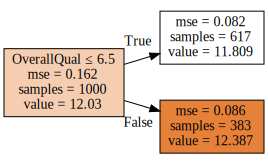

In [0]:
m = RandomForestRegressor(n_estimators=1, max_depth=1, bootstrap=False)
m.fit(trn_x, trn_y)
draw_tree(m.estimators_[0], trn_x, precision=3)

In [0]:
def calc_std(n, s, s2): return np.sqrt(s2/n - (s/n)**2)

def find_better_split(self, var_idx):
  x, y = self.x.iloc[self.idxs, var_idx].values, self.y[self.idxs]
  idxs = np.argsort(x)
  x_sorted, y_sorted = x[idxs], y[idxs]
  r_cnt, r_s, r_s2 = len(x_sorted), y_sorted.sum(), (y_sorted**2).sum()
  l_cnt, l_s, l_s2 = 0., 0., 0.

  for i in range(self.n - self.min_leaf):
    l_cnt += 1; r_cnt -= 1
    l_s += y_sorted[i]; r_s -= y_sorted[i]
    l_s2 += y_sorted[i]**2; r_s2 -= y_sorted[i]**2
    if x_sorted[i] == x_sorted[i + 1]: continue

    l_std = calc_std(l_cnt, l_s, l_s2)
    r_std = calc_std(r_cnt, r_s, r_s2)
    score = l_cnt * l_std + r_cnt * r_std
    if score < self.score:
      self.score, self.var_idx, self.split_val = score, var_idx, x_sorted[i]

In [0]:
DecisionTree.find_better_split = find_better_split

In [0]:
rf = RandomForest(trn_x, trn_y, 1)
print(rf.trees[0])
%timeit RandomForest(trn_x, trn_y, 1)

samples: 1000, value: 12.030368441695023, score: 288.6899540938478, split variable: OverallQual, split value: 6
100 loops, best of 3: 8.63 ms per loop


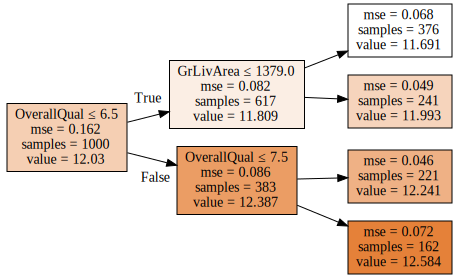

In [0]:
m = RandomForestRegressor(n_estimators=1, max_depth=2, bootstrap=False)
m.fit(trn_x, trn_y)
draw_tree(m.estimators_[0], trn_x, precision=3)

In [0]:
def find_split(self):
  for c in range(self.c):
    self.find_better_split(c)
  if not self.is_leaf:
#     pdb.set_trace()
    x = self.x.iloc[:, self.var_idx].values
    l_idxs = np.nonzero(x > self.split_val)[0]
    r_idxs = np.nonzero(x <= self.split_val)[0]
    self.lb = DecisionTree(self.x.iloc[l_idxs], self.y[l_idxs], min_leaf=5)
    self.rb = DecisionTree(self.x.iloc[r_idxs], self.y[r_idxs], min_leaf=5)

DecisionTree.find_split = find_split

In [0]:
t = RandomForest(trn_x, trn_y, 1).trees[0]
t

samples: 1000, value: 12.030368441695023, score: 288.6899540937253, split variable: OverallQual, split value: 6

In [0]:
t.rb, t.lb, t.lb.lb, t.lb.rb

(samples: 617, value: 11.809290068879918, score: 151.00603314209667, split variable: GrLivArea, split value: 1376,
 samples: 383, value: 12.386518196334503, score: 90.79697982952005, split variable: OverallQual, split value: 7,
 samples: 162, value: 12.584355513747466, score: 36.72007562937957, split variable: GrLivArea, split value: 1915,
 samples: 221, value: 12.241497176330432, score: 40.144323458391156, split variable: GrLivArea, split value: 1935)

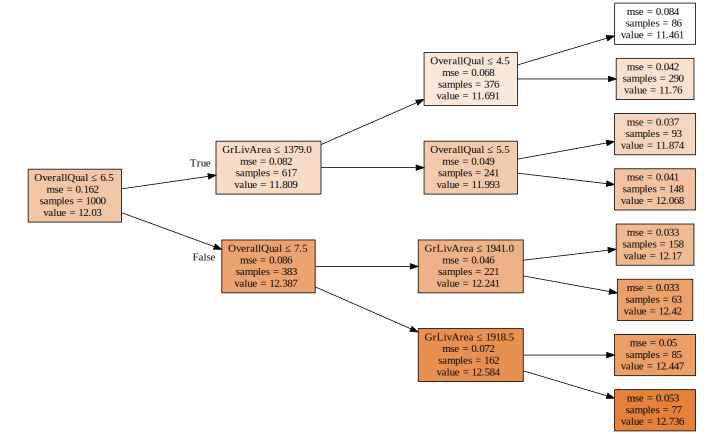

In [0]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False)
m.fit(trn_x, trn_y)
draw_tree(m.estimators_[0], trn_x, precision=3)

In [0]:
def predict(self, x):
  return [self.predict_row(xi[1]) for xi in x.iterrows()]

def predict_row(self, xi):
  if self.is_leaf: return self.val
#   pdb.set_trace()
  t = self.rb if xi[self.var_idx] <= self.split_val else self.lb
  return t.predict_row(xi)

DecisionTree.predict = predict
DecisionTree.predict_row = predict_row

In [0]:
t = RandomForest(trn_x, trn_y, 1).trees[0]
t.predict(val_x[:5])

[11.885863073819142,
 12.302415580246238,
 12.01820525741274,
 12.162324423276598,
 12.801332892890704]

In [0]:
m = RandomForestRegressor(n_estimators=1, min_samples_leaf=5, bootstrap=False)
m.fit(trn_x, trn_y)
m.predict(val_x[:5])

array([11.91777, 12.29686, 12.07584, 12.20965, 12.81889])

In [0]:
metrics.r2_score(t.predict(val_x[:5]), val_y[:5]), metrics.r2_score(m.predict(val_x[:5]), val_y[:5])

(0.9243634901216589, 0.8916108333330888)

### All of columns

In [0]:
train_cats(train_df)
df, y, nas = proc_df(train_df, 'SalePrice')
y = np.log1p(y)
trn_x, val_x, trn_y, val_y = train_test_split(df, y, test_size=0.3)
n = 1000
trn_x, trn_y = trn_x[:n], trn_y[:n]

In [0]:
class RandomForest():
  def __init__(self, x, y, nr_trees, sample_sz=1000, min_leaf=2, max_features=None):
    self.x, self.y, self.nr_trees, self.sample_sz = x, y, nr_trees, sample_sz
    self.min_leaf = min_leaf
    self.max_features = max_features if not max_features is None else 1
    self.trees = [self.create_tree() for _ in range(nr_trees)]
  
  def create_tree(self):
    idxs = np.random.permutation(len(self.x))[:self.sample_sz]
    return DecisionTree(self.x.iloc[idxs], self.y[idxs], self.min_leaf, self.max_features)

In [0]:
def calc_std(n, s, s2): return np.sqrt(s2/n - (s/n)**2)

class DecisionTree():
  def __init__(self, x, y, min_leaf, max_features, idxs=None):
    if idxs is None: idxs = np.arange(len(x))
    self.x, self.y, self.idxs = x.reset_index(drop=True), y, idxs
    self.min_leaf, self.max_features = min_leaf, max_features
    self.n, self.c = len(idxs), x.shape[1]
    self.val = self.y[idxs].mean()
    self.score = float('inf')
    self.find_split()
  
  def find_split(self):
#     pdb.set_trace()
    idxs = np.random.permutation(self.c)[:int(self.c * self.max_features)]
    for c in idxs:
      self.find_better_split(c)
    if not self.is_leaf:
      x = self.x.iloc[:, self.var_idx].values
      l_idxs = np.nonzero(x > self.split_val)[0]
      r_idxs = np.nonzero(x <= self.split_val)[0]
      self.lb = DecisionTree(self.x.iloc[l_idxs], self.y[l_idxs], self.min_leaf, self.max_features)
      self.rb = DecisionTree(self.x.iloc[r_idxs], self.y[r_idxs], self.min_leaf, self.max_features)

  def find_better_split(self, var_idx):
#     pdb.set_trace()
    x, y = self.x.iloc[self.idxs, var_idx].values, self.y[self.idxs]
    idxs = np.argsort(x)
    x_sorted, y_sorted = x[idxs], y[idxs]
    r_cnt, r_s, r_s2 = len(x_sorted), y_sorted.sum(), (y_sorted**2).sum()
    l_cnt, l_s, l_s2 = 0., 0., 0.

    for i in range(self.n - self.min_leaf):
      l_cnt += 1; r_cnt -= 1
      l_s += y_sorted[i]; r_s -= y_sorted[i]
      l_s2 += y_sorted[i]**2; r_s2 -= y_sorted[i]**2
      if x_sorted[i] == x_sorted[i + 1]: continue

      l_std = calc_std(l_cnt, l_s, l_s2)
      r_std = calc_std(r_cnt, r_s, r_s2)
      score = l_cnt * l_std + r_cnt * r_std
      if score < self.score:
        self.score, self.var_idx, self.split_val = score, var_idx, x_sorted[i]
  
  def predict(self, x):
    return [self.predict_row(xi[1]) for xi in x.iterrows()]

  def predict_row(self, xi):
    if self.is_leaf: return self.val
    t = self.rb if xi[self.var_idx] <= self.split_val else self.lb
    return t.predict_row(xi)

  @property
  def split_var(self): return self.x.columns[self.var_idx]
  
  @property
  def is_leaf(self): return self.score == float('inf')
  
  def __repr__(self):
    txt = f'samples: {self.n}, value: {self.val}, score: {self.score}, '
    if not self.is_leaf:
      txt += f'split variable: {self.split_var}, split value: {self.split_val}'
    return txt

In [0]:
t = RandomForest(trn_x, trn_y, 1, min_leaf=5, max_features=0.5).trees[0]
t

samples: 1000, value: 12.029458473021721, score: 326.4157389254301, split variable: GrLivArea, split value: 1478

In [0]:
def predict(self, x):
  return np.mean([t.predict(x) for t in self.trees], 0)

RandomForest.predict = predict

In [0]:
%time rf = RandomForest(trn_x, trn_y, 10, min_leaf=5, max_features=0.5)
metrics.r2_score(rf.predict(val_x), val_y)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


CPU times: user 1min 12s, sys: 88.9 ms, total: 1min 12s
Wall time: 1min 12s


0.82009504515188

In [0]:
m = RandomForestRegressor(n_estimators=10, n_jobs=-1, min_samples_leaf=5, max_features=0.5, bootstrap=False)
%time m.fit(trn_x, trn_y)
metrics.r2_score(m.predict(val_x), val_y)

CPU times: user 107 ms, sys: 2.99 ms, total: 110 ms
Wall time: 112 ms


0.8227169670496637

In [0]:
%time rf = RandomForest(trn_x, trn_y, 20, min_leaf=2, max_features=0.5, sample_sz=800)
metrics.r2_score(rf.predict(val_x), val_y)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


CPU times: user 3min 21s, sys: 388 ms, total: 3min 22s
Wall time: 3min 22s


0.8489631454261701

In [0]:
m = RandomForestRegressor(n_estimators=20, n_jobs=1, min_samples_leaf=2, max_features=0.5)
%time m.fit(trn_x, trn_y)
metrics.r2_score(m.predict(val_x), val_y)

CPU times: user 138 ms, sys: 1.99 ms, total: 140 ms
Wall time: 140 ms


0.8454547075884457

## Speed Up: Cython

In [0]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [0]:
def foo1(n):
  a, b = 0, 1
  while b < n:
    a = b
    b = a + b

In [0]:
%%cython
def foo2(n):
  a, b = 0, 1
  while b < n:
    a = b
    b = a + b

In [0]:
%%cython
def foo3(int n):
  cdef int a = 0
  cdef int b = 1
  cdef int tmp = 0
  while b < n:
    tmp = a
    a = b
    b = tmp + b

In [0]:
%timeit foo1(50)

1000000 loops, best of 3: 625 ns per loop


In [0]:
%timeit foo2(50)

The slowest run took 16.47 times longer than the fastest. This could mean that an intermediate result is being cached.
10000000 loops, best of 3: 188 ns per loop


In [0]:
%timeit foo3(50)

The slowest run took 35.49 times longer than the fastest. This could mean that an intermediate result is being cached.
10000000 loops, best of 3: 58.6 ns per loop


## Final

In [0]:
def calc_std(n, s, s2): return np.sqrt(s2/n - (s/n)**2)


class RandomForest():
  def __init__(self, x, y, nr_trees, sample_sz=1000, min_leaf=2, max_features=1.):
    self.x, self.y, self.nr_trees, self.sample_sz = x, y, nr_trees, sample_sz
    self.min_leaf, self.max_features = min_leaf, max_features
    self.trees = [self.create_tree() for _ in range(nr_trees)]
  
  def create_tree(self):
    idxs = np.random.permutation(len(self.x))[:self.sample_sz]
    return DecisionTree(self.x.iloc[idxs], self.y[idxs], self.min_leaf, self.max_features)

  def predict(self, x):
    return np.mean([t.predict(x) for t in self.trees], 0)


class DecisionTree():
  def __init__(self, x, y, min_leaf, max_features, idxs=None):
    if idxs is None: idxs = np.arange(len(x))
    self.x, self.y, self.idxs = x.reset_index(drop=True), y, idxs
    self.min_leaf, self.max_features = min_leaf, max_features
    self.n, self.c = len(idxs), x.shape[1]
    self.val = self.y[idxs].mean()
    self.score = float('inf')
    self.find_split()
  
  def find_split(self):
#     pdb.set_trace()
    idxs = np.random.permutation(self.c)[:int(self.c * self.max_features)]
    for c in idxs:
      self.find_better_split(c)
    if not self.is_leaf:
      x = self.x.iloc[:, self.var_idx].values
      l_idxs = np.nonzero(x > self.split_val)[0]
      r_idxs = np.nonzero(x <= self.split_val)[0]
      self.lb = DecisionTree(self.x.iloc[l_idxs], self.y[l_idxs], self.min_leaf, self.max_features)
      self.rb = DecisionTree(self.x.iloc[r_idxs], self.y[r_idxs], self.min_leaf, self.max_features)

  def find_better_split(self, var_idx):
#     pdb.set_trace()
    x, y = self.x.iloc[self.idxs, var_idx].values, self.y[self.idxs]
    idxs = np.argsort(x)
    x_sorted, y_sorted = x[idxs], y[idxs]
    r_cnt, r_s, r_s2 = len(x_sorted), y_sorted.sum(), (y_sorted**2).sum()
    l_cnt, l_s, l_s2 = 0., 0., 0.

    for i in range(self.n - self.min_leaf):
      l_cnt += 1; r_cnt -= 1
      l_s += y_sorted[i]; r_s -= y_sorted[i]
      l_s2 += y_sorted[i]**2; r_s2 -= y_sorted[i]**2
      if x_sorted[i] == x_sorted[i + 1]: continue

      l_std = calc_std(l_cnt, l_s, l_s2)
      r_std = calc_std(r_cnt, r_s, r_s2)
      score = l_cnt * l_std + r_cnt * r_std
      if score < self.score:
        self.score, self.var_idx, self.split_val = score, var_idx, x_sorted[i]
  
  def predict(self, x):
    return [self.predict_row(xi[1]) for xi in x.iterrows()]

  def predict_row(self, xi):
    if self.is_leaf: return self.val
    t = self.rb if xi[self.var_idx] <= self.split_val else self.lb
    return t.predict_row(xi)

  @property
  def split_var(self): return self.x.columns[self.var_idx]
  
  @property
  def is_leaf(self): return self.score == float('inf')
  
  def __repr__(self):
    txt = f'samples: {self.n}, value: {self.val}, score: {self.score}, '
    if not self.is_leaf:
      txt += f'split variable: {self.split_var}, split value: {self.split_val}'
    return txt